In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from arch.unitroot import PhillipsPerron
import numpy as np
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from sklearn.preprocessing import MinMaxScaler
import chow_test as chowtest
from scipy.stats import linregress
from sklearn.linear_model import LinearRegression

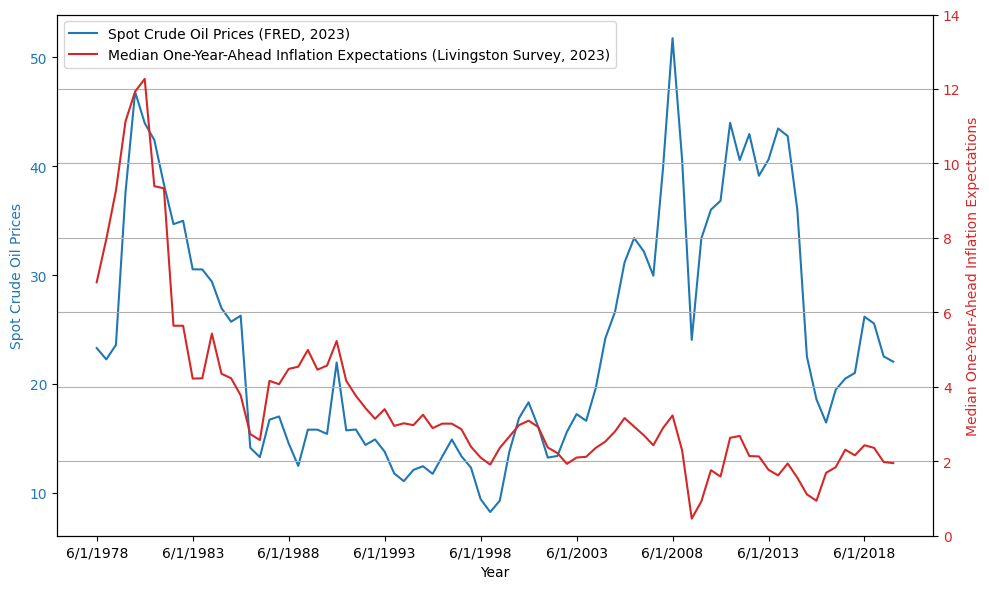

In [2]:
# Input the csv data
data = pd.read_csv("final data.csv")

years = data['Date']
inflation_expectations = data['Inflation Expectations']
oil_prices = data['Oil Prices']

# Plot oil prices on the left y-axis
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(years, oil_prices, color='tab:blue', label='Spot Crude Oil Prices (FRED, 2023)')
ax1.set_xlabel('Year')
ax1.set_ylabel('Spot Crude Oil Prices', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Plot inflation expectations on the right y-axis
ax2 = ax1.twinx()


ax2.plot(years, inflation_expectations, color='tab:red', 
         label='Median One-Year-Ahead Inflation Expectations (Livingston Survey, 2023)')
ax2.set_ylabel('Median One-Year-Ahead Inflation Expectations', color='tab:red')
ax2.set_ylim(0, 14)  
ax2.tick_params(axis='y', labelcolor='tab:red')
plt.xticks(np.arange(0, len(years), 10))

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

plt.grid(True)
plt.tight_layout()
# plt.savefig('oil.png', dpi = 300)

In [3]:
# Output normalized spread
scaler = MinMaxScaler()

inflation_array = inflation_expectations.to_numpy().reshape(-1, 1)
oil_prices_array = oil_prices.to_numpy().reshape(-1, 1)

normalized_var1 = scaler.fit_transform(inflation_array)
normalized_var2 = scaler.fit_transform(oil_prices_array)

spread = normalized_var1 - normalized_var2
spread_series = pd.Series(spread.flatten())

In [4]:
# Integer representation of years
years_int = pd.DataFrame({'Index': range(84)})

In [16]:
# Chow test:
p_valueList = []
for i in range(1, len(spread)-1):
    print("Index:", i)
    chow_statistic, p_value = chowtest.chow_test(years_int, spread_series, i, i+1, 0.05)
    p_valueList.append(p_value)
index_break = p_valueList.index(min(p_valueList))+1 # plus one because we started from 1, not 0

Index: 1
Fail to reject the null hypothesis of equality of regression coefficients in the two periods.
Chow Statistic: 0.14495903703827215, P_value: 0.8652872925130268
Index: 2
Fail to reject the null hypothesis of equality of regression coefficients in the two periods.
Chow Statistic: 0.6354632394727748, P_value: 0.5323756952115655
Index: 3
Fail to reject the null hypothesis of equality of regression coefficients in the two periods.
Chow Statistic: 0.666532620935538, P_value: 0.5163494691652141
Index: 4
Fail to reject the null hypothesis of equality of regression coefficients in the two periods.
Chow Statistic: 0.4855386542897101, P_value: 0.6171897683211345
Index: 5
Fail to reject the null hypothesis of equality of regression coefficients in the two periods.
Chow Statistic: 0.2096799286311056, P_value: 0.8112935232244034
Index: 6
Fail to reject the null hypothesis of equality of regression coefficients in the two periods.
Chow Statistic: 0.6176578448887912, P_value: 0.541789096418158

Reject the null hypothesis of equality of regression coefficients in the two periods.
Chow Statistic: 39.99552638877591, P_value: 1.0047518372857667e-12
Index: 59
Reject the null hypothesis of equality of regression coefficients in the two periods.
Chow Statistic: 38.72723949870531, P_value: 1.8964829706646924e-12
Index: 60
Reject the null hypothesis of equality of regression coefficients in the two periods.
Chow Statistic: 32.05354999116716, P_value: 6.42175201903683e-11
Index: 61
Reject the null hypothesis of equality of regression coefficients in the two periods.
Chow Statistic: 20.26574814290327, P_value: 7.865331719258961e-08
Index: 62
Reject the null hypothesis of equality of regression coefficients in the two periods.
Chow Statistic: 18.71045185783753, P_value: 2.228676031501564e-07
Index: 63
Reject the null hypothesis of equality of regression coefficients in the two periods.
Chow Statistic: 18.762222411400028, P_value: 2.1517753601152378e-07
Index: 64
Reject the null hypothesi

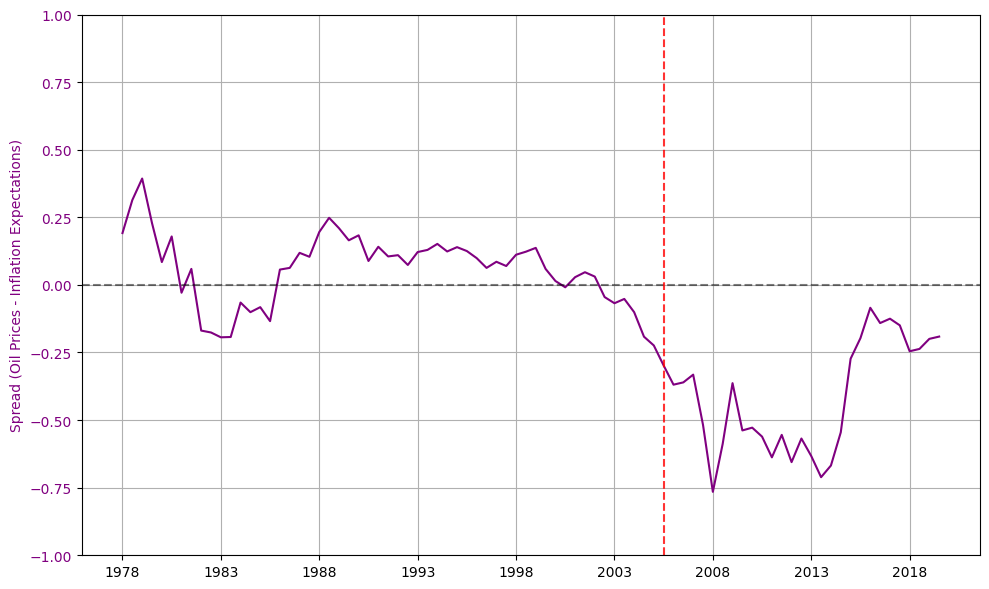

In [17]:
# Set 55 as the threshold for structural break
years = np.arange(1978, 2020, 0.5)

fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.plot(years, spread, color='purple', label='Spread (Oil Prices - Inflation Expectations)')
ax1.set_ylabel('Spread (Oil Prices - Inflation Expectations)', color='purple')
ax1.tick_params(axis='y', labelcolor='purple')
ax1.axhline(0, color='black', linestyle='--', alpha=0.5)  
ax1.set_ylim(-1, 1)
plt.grid(True)
plt.tight_layout()
x_value = years[index_break]
plt.xticks(np.arange(1978, 2022, 5)) 
ax1.axvline(x_value, color='red', linestyle='--', alpha=0.8, label=f'Vertical Line at x={x_value}')
plt.show()

Regression Line Equations:
Spread Before = -0.0039 * Year + 7.7919
Spread After = 0.0238 * Year + -48.2212


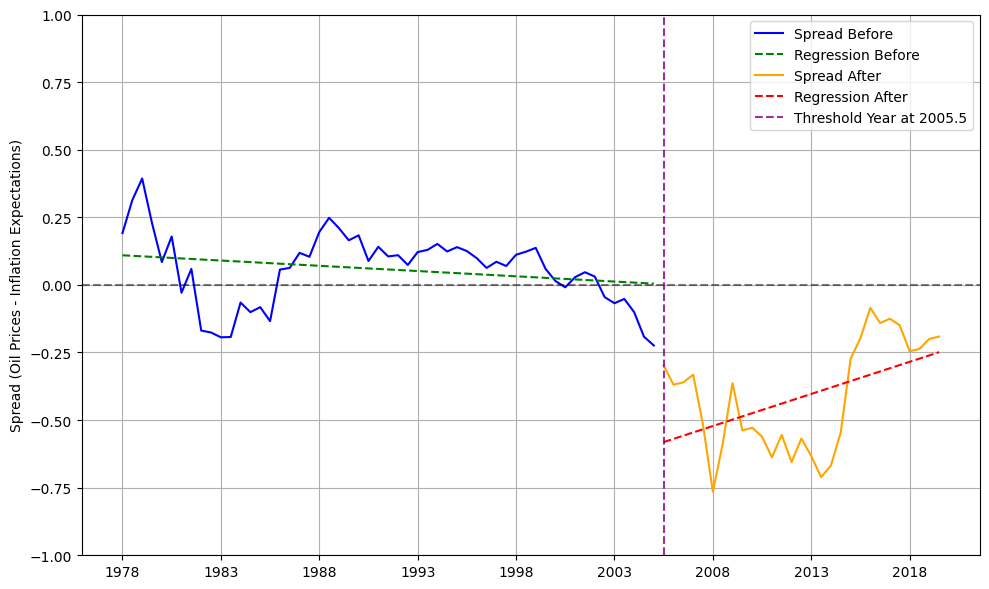

In [18]:
years = np.arange(1978, 2020, 0.5)  # assuming half-year intervals

# Threshold for splitting data
threshold_year = years[index_break] 

# Split data based on the threshold
years_before = years[years < threshold_year]
spread_before = spread[:len(years_before)]

years_after = years[years >= threshold_year]
spread_after = spread[len(years_before):]

# Fit linear regression models
regression_before = LinearRegression().fit(years_before.reshape(-1, 1), spread_before)
regression_after = LinearRegression().fit(years_after.reshape(-1, 1), spread_after)

# Plotting
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot spread and regression line before threshold
ax1.plot(years_before, spread_before, color='blue', label='Spread Before')
ax1.plot(years_before, regression_before.predict(years_before.reshape(-1, 1)), color='green', linestyle='--', label='Regression Before')

# Plot spread and regression line after threshold
ax1.plot(years_after, spread_after, color='orange', label='Spread After')
ax1.plot(years_after, regression_after.predict(years_after.reshape(-1, 1)), color='red', linestyle='--', label='Regression After')

coef_before = regression_before.coef_[0]
intercept_before = regression_before.intercept_
coef_after = regression_after.coef_[0]
intercept_after = regression_after.intercept_

# Convert coefficients and intercepts to regular Python floats
coef_before_float = float(coef_before)
intercept_before_float = float(intercept_before)
coef_after_float = float(coef_after)
intercept_after_float = float(intercept_after)

# Output regression line equations
equation_before = f"Spread Before = {coef_before_float:.4f} * Year + {intercept_before_float:.4f}"
equation_after = f"Spread After = {coef_after_float:.4f} * Year + {intercept_after_float:.4f}"

print("Regression Line Equations:")
print(equation_before)
print(equation_after)

ax1.set_ylabel('Spread (Oil Prices - Inflation Expectations)')
ax1.axhline(0, color='black', linestyle='--', alpha=0.5)
ax1.set_ylim(-1, 1)  # Adjust y-axis limits as needed
plt.grid(True)
plt.xticks(np.arange(1978, 2022, 5))  # Adjust x-axis ticks as needed
ax1.axvline(threshold_year, color='purple', linestyle='--', alpha=0.8, label=f'Threshold Year at {threshold_year}')
plt.legend()
plt.tight_layout()
plt.show()



In [29]:
# Dataset preparation
inflation_expectations = data['Inflation Expectations']
oil_prices = data['Oil Prices']
oil_prices_diff = oil_prices.diff().dropna()
inflation_expectations_diff = inflation_expectations.diff().dropna()

rawFirstSCOP = oil_prices[0:55]
rawSecondSCOP = oil_prices[55:]
rawFirstMOIE = inflation_expectations[0:55]
rawSecondMOIE = inflation_expectations[55:]
diffFirstSCOP = oil_prices_diff[0:55]
diffSecondSCOP = oil_prices_diff[55:]
diffFirstMOIE = inflation_expectations_diff[0:55]
diffSecondMOIE = inflation_expectations_diff[55:]

84


In [35]:
# ADF tests
dataset = rawFirstSCOP
datasetList = [("raw first SCOP", rawFirstSCOP), 
               ("raw second SCOP", rawSecondSCOP), 
               ("raw first MOIE", rawFirstMOIE), 
               ("raw second MOIE", rawSecondMOIE), 
               ("diff first SCOP", diffFirstSCOP), 
               ("diff second SCOP", diffSecondSCOP), 
               ("diff first MOIE", diffFirstMOIE), 
               ("diff second MOIE", diffSecondMOIE)]

for i in range(len(datasetList)):
    name, dataset = datasetList[i]
    print(name)
    adftest = adfuller(dataset, autolag='AIC', regression='c')
    print("No trend")
    print("ADF-Statistic:", round(adftest[0], 3))
    print("P-Value:", round(adftest[1], 3))
    adftest = adfuller(dataset, autolag='AIC', regression='ct')
    print("Trend")
    print("ADF-Statistic:", round(adftest[0], 3))
    print("P-Value:", round(adftest[1], 3))
    print("\n")
    
# adftest = adfuller(oil_prices, autolag='AIC', regression='ct')
# print("ADF Test Results")
# print("Null Hypothesis: The series has a unit root (non-stationary)")
# print("ADF-Statistic:", adftest[0])
# print("P-Value:", adftest[1])
# print("Number of lags:", adftest[2])
# print("Number of observations:", adftest[3])
# print("Critical Values:", adftest[4])
# print("Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary")

raw first SCOP
No trend
ADF-Statistic: -1.37
P-Value: 0.596
Trend
ADF-Statistic: -1.254
P-Value: 0.899


raw second SCOP
No trend
ADF-Statistic: -2.02
P-Value: 0.278
Trend
ADF-Statistic: -2.874
P-Value: 0.171


raw first MOIE
No trend
ADF-Statistic: -3.946
P-Value: 0.002
Trend
ADF-Statistic: -5.274
P-Value: 0.0


raw second MOIE
No trend
ADF-Statistic: -2.683
P-Value: 0.077
Trend
ADF-Statistic: -2.615
P-Value: 0.273


diff first SCOP
No trend
ADF-Statistic: -5.599
P-Value: 0.0
Trend
ADF-Statistic: -5.611
P-Value: 0.0


diff second SCOP
No trend
ADF-Statistic: -4.455
P-Value: 0.0
Trend
ADF-Statistic: -4.009
P-Value: 0.009


diff first MOIE
No trend
ADF-Statistic: -6.658
P-Value: 0.0
Trend
ADF-Statistic: -6.644
P-Value: 0.0


diff second MOIE
No trend
ADF-Statistic: -3.448
P-Value: 0.009
Trend
ADF-Statistic: -2.917
P-Value: 0.157




In [ ]:
# PP Tests



In [73]:
df = pd.DataFrame({
    'inflation_expectations_diff': inflation_expectations_diff[24:],
    'oil_prices_diff': oil_prices_diff[24:]
})

# Perform Johansen cointegration test
result = coint_johansen(df, det_order=0, k_ar_diff=1)

# Print the results
print("Eigenvalues:")
print(result.eig)
print("\nTrace statistic:")
print(result.lr1)
print("\nCritical values (90%, 95%, 99%):")
print(result.cvt)
print("\nEigen statistic:")
print(result.lr2)
print("\nCritical values (90%, 95%, 99%):")
print(result.cvm)

Eigenvalues:
[0.95890471 0.43553329]

Trace statistic:
[30.10988572  4.57499101]

Critical values (90%, 95%, 99%):
[[13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]

Eigen statistic:
[25.53489471  4.57499101]

Critical values (90%, 95%, 99%):
[[12.2971 14.2639 18.52  ]
 [ 2.7055  3.8415  6.6349]]
